In [1]:
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

plt.rcParams.update({'figure.max_open_warning': 0})

## EDA ##

Here, we open the data we put together in the previous notebook. For the first analysis, we look at $cancer\_type$, $patient\_barcode$, $gene$ and $gene_type$.

In [2]:
print('Loading data ...')
mutations = {}
mutations['train'] = pd.read_csv("./data/somatic_mutations_train.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
mutations['test']  = pd.read_csv("./data/somatic_mutations_test.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
print("done.")
print("Mutations training data count:", mutations['train']['patient_barcode'].count())
print("Mutations test data count:    ", mutations['test']['patient_barcode'].count())

Loading data ...
done.
Mutations training data count: 2775593
Mutations test data count:     795283


First, eliminate non-coding genes.  This is a common filter applied in bioinformatics to ensure that
only genes that code for proteins are included in the analysis.

In [3]:
# Eliminate non-coding genes
def eliminateNonCodingGenes(data):
    before_count               = data.gene.nunique()
    data                       = data[data.gene_type == 'protein_coding']
    after_count                = data.gene.nunique()
    print("Filtered out ", str(before_count -after_count), "genes")


eliminateNonCodingGenes(mutations['train'])
eliminateNonCodingGenes(mutations['test'])

Filtered out  2062 genes
Filtered out  1822 genes


Genes by patient frequency
  mean: 102
  min:  1
  max:  3092


Text(0, 0.5, 'Number of Patient Tumors (gene is present in)')

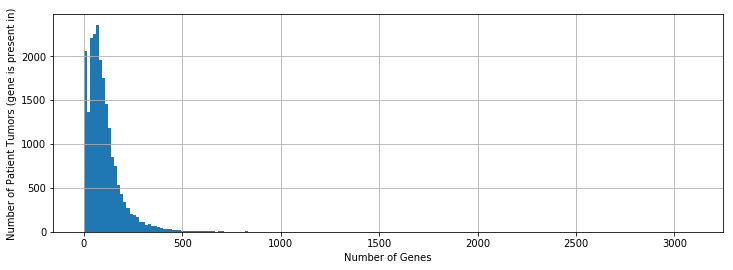

In [4]:
# Show the distribution of genes across patient tumors
gene_count         = mutations['train'].groupby(['gene'])['patient_barcode'].nunique().reset_index(name='count')
gene_count.columns = ['gene', 'patient_count']
gene_count         = gene_count.sort_values(['patient_count', 'gene'], ascending=[0,1])
print('Genes by patient frequency')
print("  mean:", int(gene_count['patient_count'].mean()))
print("  min: ", int(gene_count['patient_count'].min()))
print("  max: ", int(gene_count['patient_count'].max()))
gene_count.head(10)

ax = gene_count['patient_count'].hist(bins=200, figsize=(12,4))
ax.set_xlabel("Number of Genes")
ax.set_ylabel("Number of Patient Tumors (gene is present in)")

From the histogram above, it is clear that even through we have a large number of genes, only a small number of them are turned on in the patient tumor data that we have. This is the classic problem of a large feature space with a much smaller number of samples. Hence we will need to perform a dimensionality reduction technique such as PCA here.


Number of cancer types: 32

Number of patients: 8006


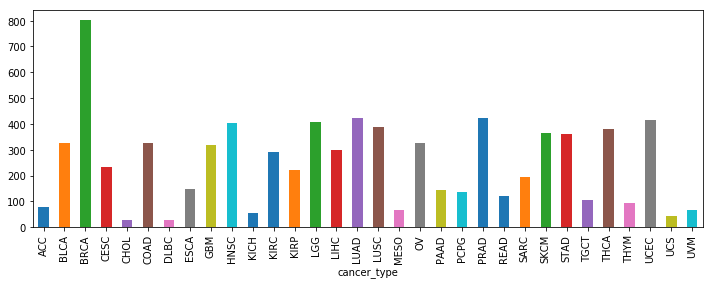

In [5]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['train'].cancer_type.unique()
print("\nNumber of cancer types:", len(cancer_types))

# Get number of cases per cancer type
group_patients_by_cancer = mutations['train'].groupby(['cancer_type'])['patient_barcode'].nunique()
print("\nNumber of patients:", group_patients_by_cancer.sum())
group_patients_by_cancer.plot.bar(figsize=(12,4))

The above chart shows that there are some cancers, such as BRCA and LUAD that have a large representation in our dataset, but other such as DBLC and UCS that are present in much smaller numbers. This will present a challenge for our classifier. Specifically, we want our classifier to be able to classify each of the 32 types of cancers with high precision, but the model should also be able to identify the cancers that don't have a proportionate representation in our data set. It could be that these are cancers are rare, or perhaps they are simply rare in our dataset. **Note:** add more details about the cancers that are abundant as well as rare in this dataset.

Mean number of genes represented for each cancer type: 11626
Min number of genes represented for each cancer type:  1458
Max number of genes represented for each cancer type:  20844


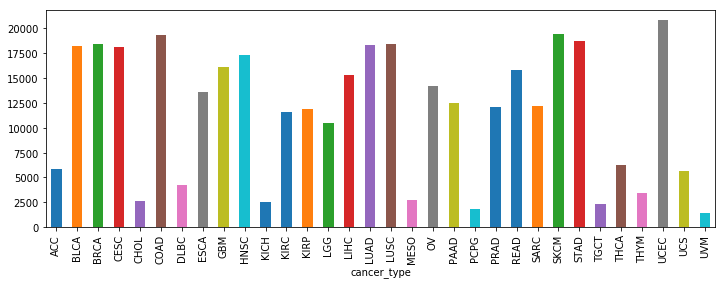

In [6]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations['train'].groupby(['cancer_type'])['gene'].nunique();
group_genes_by_cancer.plot.bar(figsize=(12,4))
print("Mean number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.mean())))
print("Min number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.min())))
print("Max number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.max())))

The above bar chart gives us an idea of how many genes (features for us) are _on_ for each of the cancer types. Cross referencing this chart with the previous one, we see that for some cancers such as DLBC and UCS we have a fair number of active features, even though the number of cases of such cancers are low. We should be able to person isolated (one-vs-rest) analysis for these cases. However, for other cancers, such as KICH (Kidney Chromophobe) and UVM (Uveal Melanoma) we have both a low occurance rate, and a low number of active features. This second category of cancers will need to be handled with care.

Now we create data files by feature counts.

In [7]:
# Create feature matrix each row is a patient tumor; each column is a gene
def createPatientRowFeatureMatrix(mutations, feature_genes, description, save=True):
    cases = list()
    grouped = mutations.groupby('patient_barcode')
    i = int(0)

    cols = ['case_id', 'cancer_type']
    for gene in feature_genes:
        cols.append(gene)


    for name, group in grouped:
        case = list()
        case.append(name)
        for cc in group.cancer_type.head(1):
            case.append(cc)

        for gene_flag in feature_genes.isin(group.gene.unique()):
            switch = 0
            if gene_flag == True:
                switch = 1
            case.append(switch)
        cases.append(case)


    cases_df = pd.DataFrame(cases)
    cases_df.columns = cols
    print("  number of rows in dataset", cases_df.case_id.count())
    print("  number of cols in dataset", len(cols))
    
    # Write out transformed data to csv
    if save:
        fileName = "./data/" + description + ".csv"
        print("  writing", fileName, "...")
        cases_df.to_csv(fileName)
        print("  done.")
    
    return cases_df


In [8]:
def showGenesAcrossCancerTypes(top_gene_cancer_matrix, top_n_gene_count, total_gene_count):
    plt.rcParams["figure.figsize"] = (10,4)
    sums_by_cancer_type = top_gene_cancer_matrix.sum(axis=1, skipna=True, numeric_only=True) 
    sorted = sums_by_cancer_type.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'patient_count']
    df.reset_index()    
    title = 'Patient counts for genes (top ' + str(top_n_gene_count) + ')';
    ax = df.head(50).plot.bar(x='gene', y='patient_count', legend=None, title=title)

    cancer_type_present_count = top_gene_cancer_matrix.astype(bool).sum(axis=1, skipna=True, numeric_only=True)
    sorted = cancer_type_present_count.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'present_in_cancer_type_count']
    df.reset_index()    

    axarr = df.hist(bins=32)

    for ax in axarr.flatten():
        ax.set_xlabel("Number of cancer types gene is present")
        ax.set_ylabel("Gene frequency")
    
    return df

In [9]:

def showGenesForCancerType(cancer_type, sorted_genes):
    plt.rcParams["figure.figsize"] = (20,3)
    df = pd.DataFrame(sorted_genes).reset_index()
    df.columns = ['gene', 'count']
    df.reset_index()    
    ax = df.head(50).plot.bar(x='gene', y='count', legend=None, title=cancer_type)
    

In [10]:

def createFeatureMatrix(mutations_train, mutations_test, top_n_gene_count, save, description, charts=True):
    print("Formatting gene matrix with top ", top_n_gene_count, "genes from each cancer type")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    
    

    # Now find the top n genes for each cancer type
    top_genes = []
    idx = 0

    plt.rcParams["figure.figsize"] = (20,20)
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        top_rows = sorted_genes[sorted_genes > 0].head(top_n_gene_count)
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is gene, column for each cancer type
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    print("  number of genes:", top_gene_cancer_matrix.shape[0])
    if charts:
        showGenesAcrossCancerTypes(top_gene_cancer_matrix, 
                                   top_n_gene_count, 
                                   top_gene_cancer_matrix.shape[0] )
    feature_genes = top_gene_cancer_matrix.index
    print("  number of genes after filter:", len(feature_genes))
    createPatientRowFeatureMatrix(mutations_train, feature_genes, description + ".train", save)
    createPatientRowFeatureMatrix(mutations_test,  feature_genes, description + ".test", save)

In [11]:
def createBestFitFeatureMatrix(mutations_train, mutations_test, top_n_genes, n_features, 
                               save, description, charts=True):
    print("Formatting gene matrix with best fit for", n_features, "features")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    
    

    # Now find the top n genes for each cancer type
    top_genes = []
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        if (top_n_genes == None):
            top_rows = sorted_genes[sorted_genes > 0].head(top_n_genes)
        else:
            top_rows = sorted_genes
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is patient, column for each gene
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    showGenesAcrossCancerTypes(top_gene_cancer_matrix, 
                               top_n_genes, 
                               n_features )

    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = top_gene_cancer_matrix.index
    print("  number of genes before best fit:     ", len(feature_genes))
    feature_matrix_train = createPatientRowFeatureMatrix(mutations_train, feature_genes, '', False)
    feature_matrix_test  = createPatientRowFeatureMatrix(mutations_test, feature_genes, '', False)
    
    #
    #  Try BestFit (chi squared test) to find most
    #  important genes
    #
    best_genes  = getBestFitFeatures(feature_matrix_train, n_features)
    cancer_type = feature_matrix_train['cancer_type']
    case_id     = feature_matrix_train['case_id']
    data_train  = feature_matrix_train.loc[:, feature_matrix_train.columns.isin(best_genes)]
    
    print("  number of genes before after best fit:", data_train.shape[1])
    final_feature_matrix_train = pd.concat([case_id, cancer_type, data_train], axis=1)

    cancer_type = feature_matrix_test['cancer_type']
    case_id     = feature_matrix_test['case_id']
    data_test  = feature_matrix_test.loc[:, feature_matrix_test.columns.isin(best_genes)]
    final_feature_matrix_test = pd.concat([case_id, cancer_type, data_test], axis=1)
    
    if save:
        fileName = "./data/" + description  + ".train.csv"
        print("  writing", fileName, "...")
        final_feature_matrix_train.to_csv(fileName)
        print("  done.")        
        
        fileName = "./data/" + description  + ".test.csv"
        print("  writing", fileName, "...")
        final_feature_matrix_test.to_csv(fileName)
        print("  done.")        

In [12]:
def getBestFitFeatures(feature_matrix, n_features):
    #apply SelectKBest class to extract top 10 best features
    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    
    data = feature_matrix.loc[:, (feature_matrix.columns != 'cancer_type') & (feature_matrix.columns != 'case_id')]
    labels_string = feature_matrix['cancer_type']
    
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)
    
    fit = bestfeatures.fit(data,labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['gene','score']  
    display(featureScores.nlargest(10,'score'))  
    return list(featureScores.nlargest(n_features,'score')['gene'])

In [13]:
def createAllFeatureMatrix(mutations_train, mutations_test, save, description):
    print("Formatting gene matrix with for all features")
    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = pd.Series(mutations_train.gene.unique())
    feature_matrix_train = createPatientRowFeatureMatrix(mutations_train, feature_genes, description + ".train", save)
    feature_matrix_test = createPatientRowFeatureMatrix(mutations_test,  feature_genes, description + ".test", save)
    return feature_matrix_train, feature_matrix_test

In [14]:
def trimWithL1(train_features, test_features, label_encoder, description, save):
    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)

    params = {'C':  [100, 10, 1, .5]}
    
    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
        # Fit model
        l1.fit(train_data, train_labels) 


        # Get the features with non-zero coefficients.  We will use
        # this list to reduce the features 
        non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
        names = np.array(list(train_data.columns))
        non_zero_genes = names[non_zero_sums] 


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        trimmed_train_data = train_data[non_zero_genes]
        trimmed_test_data  = test_data[non_zero_genes]
        
        final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
        final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
        
        if save:
            fileName = "./data/" + description + "_c" + str(c_param) + ".train.csv"
            print("  writing", fileName, "...")
            final_features_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description + "_c" + str(c_param) + ".test.csv"
            print("  writing", fileName, "...")
            final_features_test.to_csv(fileName)
            print("  done.")        
        


Formatting gene matrix with top  1000 genes from each cancer type
  number of genes: 9007
  number of genes after filter: 9007
  number of rows in dataset 8006
  number of cols in dataset 9009
  writing ./data/features_topgenes_small.train.csv ...
  done.
  number of rows in dataset 2002
  number of cols in dataset 9009
  writing ./data/features_topgenes_small.test.csv ...
  done.


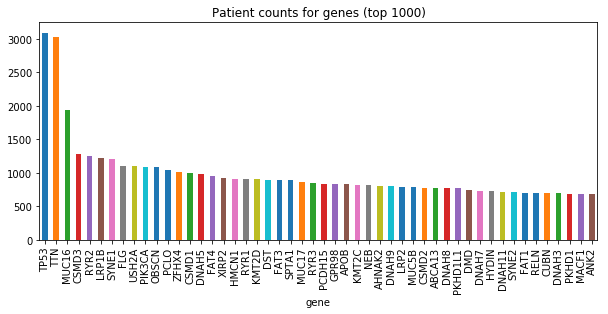

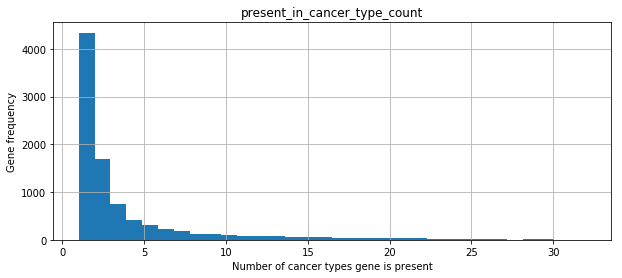

In [15]:
# Create a feature matrix, getting the top n genes that are most frequent
# per label (cancer type).  Merge these genes and create a feature matrix,
# one row per patient tumor, column for each merged gene
createFeatureMatrix(mutations['train'], mutations['test'], 1000, True, 'features_topgenes_small')

Formatting gene matrix with best fit for 5000 features
  number of genes before best fit:      21260
  number of rows in dataset 8006
  number of cols in dataset 21262
  number of rows in dataset 2002
  number of cols in dataset 21262


,gene,score
8140,IDH1,4037.799966
20050,VHL,2813.522017
1923,BRAF,2652.147976
1125,APC,2426.304370
9278,KRAS,2029.327769
14382,PTEN,1869.681827
8406,IGLV3-1,1515.025414
19014,TP53,1484.858122
5003,DNAH5,1356.796031
7068,GNAQ,1211.510984


  number of genes before after best fit: 5000
  writing ./data/features_bestfit_with_topgenes.train.csv ...
  done.
  writing ./data/features_bestfit_with_topgenes.test.csv ...
  done.


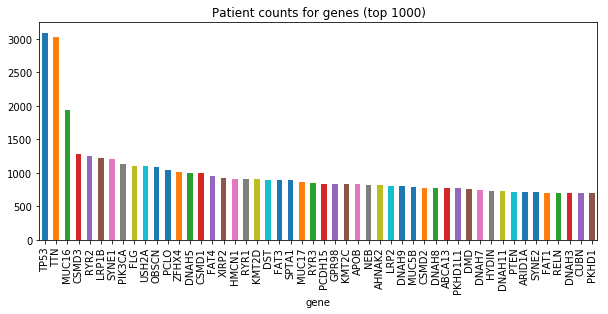

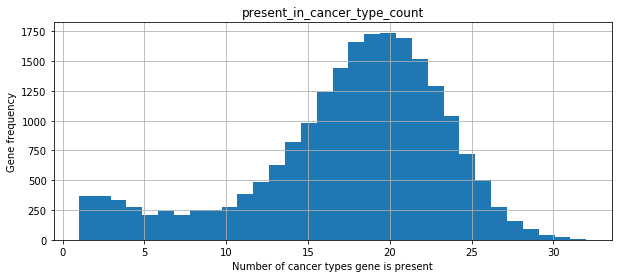

In [16]:
# Create a feature matrix, getting the top 1000 genes that are most frequent
# per label (cancer type).  Merge these genes.
# Then use sklearn BestFit to find top 5000 genes.
# Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
createBestFitFeatureMatrix(mutations['train'], mutations['test'], 1000, 5000, True, 
                           'features_bestfit_with_topgenes')

Formatting gene matrix with best fit for 5000 features
  number of genes before best fit:      21260
  number of rows in dataset 8006
  number of cols in dataset 21262
  number of rows in dataset 2002
  number of cols in dataset 21262


,gene,score
8140,IDH1,4037.799966
20050,VHL,2813.522017
1923,BRAF,2652.147976
1125,APC,2426.304370
9278,KRAS,2029.327769
14382,PTEN,1869.681827
8406,IGLV3-1,1515.025414
19014,TP53,1484.858122
5003,DNAH5,1356.796031
7068,GNAQ,1211.510984


  number of genes before after best fit: 5000
  writing ./data/features_bestfit_med.train.csv ...
  done.
  writing ./data/features_bestfit_med.test.csv ...
  done.


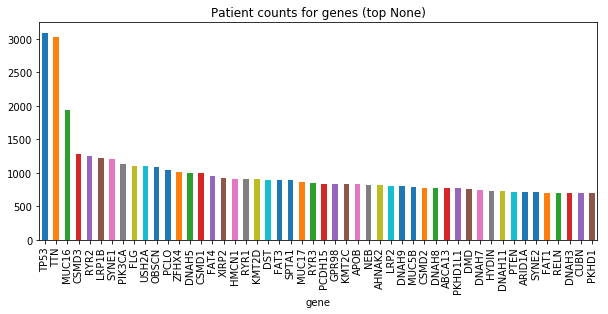

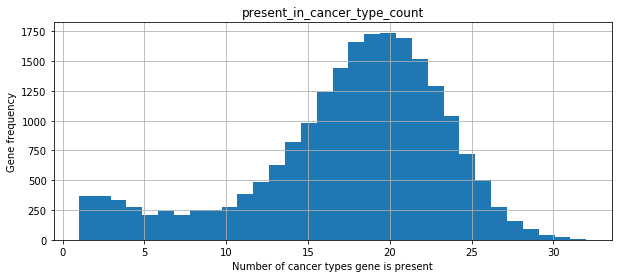

In [17]:
# Create a feature matrix, using sklearn BestFit to find top 
# 5000 genes. Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
createBestFitFeatureMatrix(mutations['train'], mutations['test'], None, 5000, True,  
                           'features_bestfit_med')

Formatting gene matrix with best fit for 8000 features
  number of genes before best fit:      21260
  number of rows in dataset 8006
  number of cols in dataset 21262
  number of rows in dataset 2002
  number of cols in dataset 21262


,gene,score
8140,IDH1,4037.799966
20050,VHL,2813.522017
1923,BRAF,2652.147976
1125,APC,2426.304370
9278,KRAS,2029.327769
14382,PTEN,1869.681827
8406,IGLV3-1,1515.025414
19014,TP53,1484.858122
5003,DNAH5,1356.796031
7068,GNAQ,1211.510984


  number of genes before after best fit: 8000
  writing ./data/features_bestfit_large.train.csv ...
  done.
  writing ./data/features_bestfit_large.test.csv ...
  done.


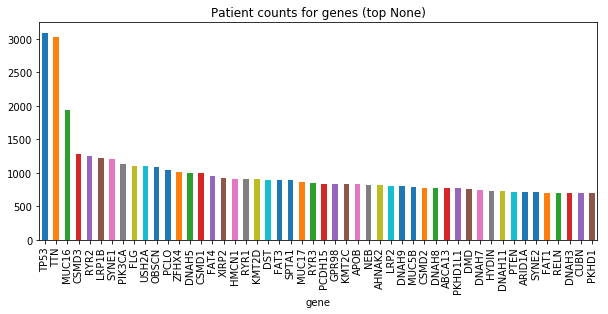

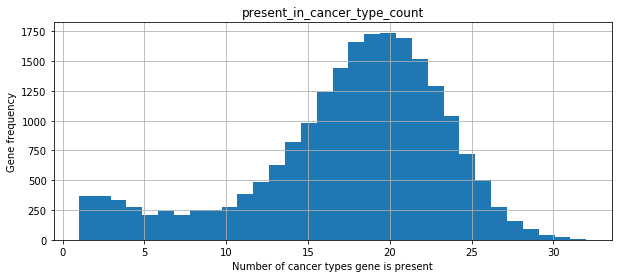

In [18]:
# Create a feature matrix, using sklearn BestFit to find top 
# 8000 genes. Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
createBestFitFeatureMatrix(mutations['train'], mutations['test'],None, 8000, True,  
                           'features_bestfit_large')

In [19]:
# Create a feature matrix,  Feature matrix will have one row per patient tumor, 
# column for every gene encountered in training data set.
feature_matrix_train, feature_matrix_test = createAllFeatureMatrix(mutations['train'], 
                                                                   mutations['test'], True, 'features_all')

Formatting gene matrix with for all features
  number of rows in dataset 8006
  number of cols in dataset 21262
  writing ./data/features_all.train.csv ...
  done.
  number of rows in dataset 2002
  number of cols in dataset 21262
  writing ./data/features_all.test.csv ...
  done.


In [20]:
#
# Trim the features using Logistic Regression, L1 regularization
#
label_encoder            = preprocessing.LabelEncoder()
trimWithL1(feature_matrix_train, feature_matrix_test, label_encoder,
           'features_l1reg', True)

  writing ./data/features_l1reg_c0.5.train.csv ...
  done.
  writing ./data/features_l1reg_c0.5.test.csv ...
  done.
  writing ./data/features_l1reg_c1.train.csv ...
  done.
  writing ./data/features_l1reg_c1.test.csv ...
  done.
  writing ./data/features_l1reg_c10.train.csv ...
  done.
  writing ./data/features_l1reg_c10.test.csv ...
  done.
  writing ./data/features_l1reg_c100.train.csv ...
  done.
  writing ./data/features_l1reg_c100.test.csv ...
  done.
